<a href="https://colab.research.google.com/github/rishisethia258/PINN-diffusion/blob/main/2D%20Problems/PINN_2d_Neumann_Partial_Boundary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
!pip install deepxde
from deepxde.backend import tf
import deepxde as dde
import numpy as np
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 4.7 MB/s eta 0:00:00
No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [ ]:
# Constants
LENGTH_OF_DOMAIN = 1
BREADTH_OF_DOMAIN = 2
TIME = 1
INITIAL_CONC = 0
D = 0.1
J = 1

In [ ]:
# Domain Definition
RectangularDomain = dde.geometry.Rectangle([0, 0], [LENGTH_OF_DOMAIN, BREADTH_OF_DOMAIN])
TimeDomain = dde.geometry.TimeDomain(0, TIME)
CombinedDomain = dde.geometry.GeometryXTime(RectangularDomain, TimeDomain)

In [ ]:
# Boundary Condition
def l_boundary(X, on_boundary):
  return np.isclose(X[0], 0) and X[1] >= 0 and X[1] <= 0.5

l_bc = dde.icbc.NeumannBC(CombinedDomain, lambda X: J, l_boundary)
initial_bc = dde.icbc.IC(CombinedDomain, lambda X : INITIAL_CONC, lambda _, on_initial : on_initial)

In [ ]:
# PDE definition
def pde(X, u):
  # X = [x y t] Dataset which contains all possible data points in spatio-temportal domain
  du_dt = dde.grad.jacobian(u, X, i = 0, j = 2)
  ddc_dxx = dde.grad.hessian(u, X, i = 0, j = 0)
  ddc_dyy = dde.grad.hessian(u, X, i = 0, j = 1)
  return du_dt - D * (ddc_dxx + ddc_dyy)

In [ ]:
# PDE module
module = dde.data.TimePDE(
    CombinedDomain,
    pde,
    [l_bc, initial_bc],
    num_domain = 10000,
    num_boundary = 10000,
    num_initial = 5000,
    num_test = 10000,
)

In [ ]:
# Defining and Compiling Model
net = dde.nn.FNN([3] + [56] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(module, net)
model.compile("adam", lr = 0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.080323 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.643489 s



Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.35e-03, 7.58e-01, 2.32e-02]    [4.77e-03, 7.58e-01, 2.32e-02]    []  
1000      [2.14e-04, 3.86e-04, 7.93e-04]    [1.31e-04, 3.86e-04, 7.93e-04]    []  
2000      [1.32e-04, 4.49e-05, 2.56e-04]    [1.12e-04, 4.49e-05, 2.56e-04]    []  
3000      [7.13e-05, 2.84e-05, 1.83e-04]    [6.19e-05, 2.84e-05, 1.83e-04]    []  
4000      [5.18e-05, 1.98e-05, 1.53e-04]    [4.47e-05, 1.98e-05, 1.53e-04]    []  
5000      [3.61e-05, 1.72e-05, 1.26e-04]    [3.04e-05, 1.72e-05, 1.26e-04]    []  
6000      [2.53e-05, 1.04e-05, 9.66e-05]    [2.68e-05, 1.04e-05, 9.66e-05]    []  
7000      [2.10e-05, 9.44e-06, 8.13e-05]    [2.43e-05, 9.44e-06, 8.13e-05]    []  
8000      [1.80e-05, 8.31e-06, 6.89e-05]    [2.18e-05, 8.31e-06, 6.89e-05]    []  
9000      [1.46e-05, 6.95e-06, 5.68e-05]    [1.78e-05, 6.95e-06, 5.68e-05]    []  
10000     [1.65e-05, 7.93e-06, 5.26

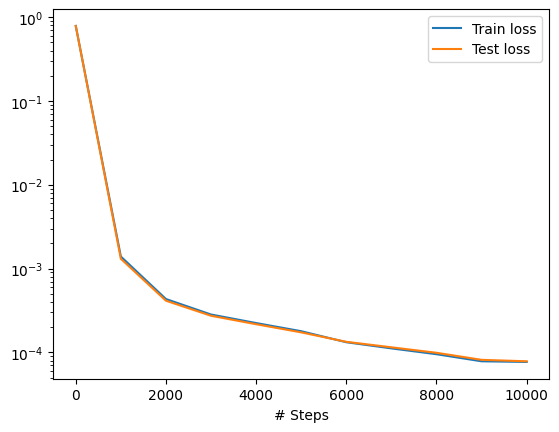

In [ ]:
# Training Model
LossHistory, TrainState = model.train(iterations = 10000)
dde.saveplot(LossHistory, TrainState, issave = True, isplot = True)

In [ ]:
# Finding PINN Solution
ux = np.linspace(0, LENGTH_OF_DOMAIN, (LENGTH_OF_DOMAIN * 50) + 1, dtype = "float")
uy = np.linspace(0, BREADTH_OF_DOMAIN, (BREADTH_OF_DOMAIN * 50) + 1, dtype = "float")
ut = np.linspace(0, TIME, (TIME * 20) + 1, dtype = "float")
x, y, t = np.meshgrid(ux, uy, ut)

X = np.array([x.flatten(), y.flatten(), t.flatten()]).T
new_X = X[np.array(list(map(RectangularDomain.inside, X[:, : -1])))]

predicted_c = model.predict(new_X)
model_X_pinn = np.insert(new_X, [2], predicted_c.reshape((-1, 1)), axis = 1)

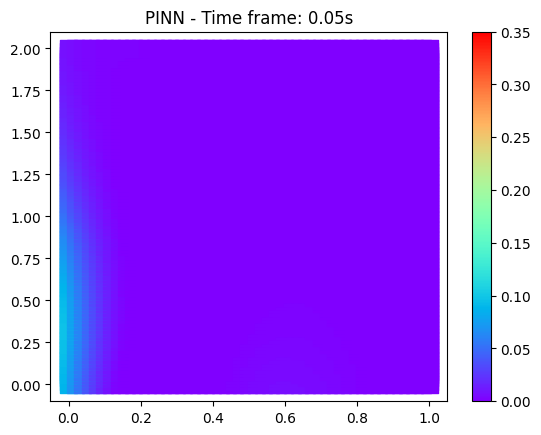

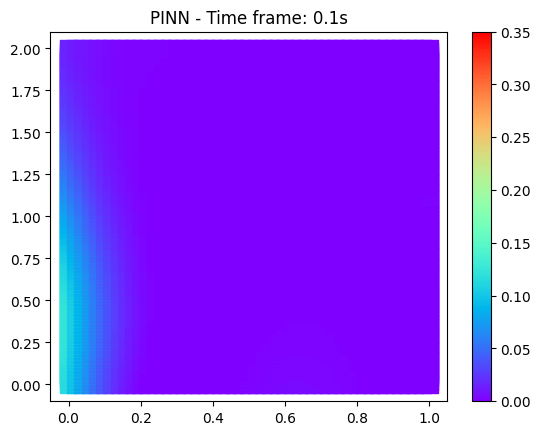

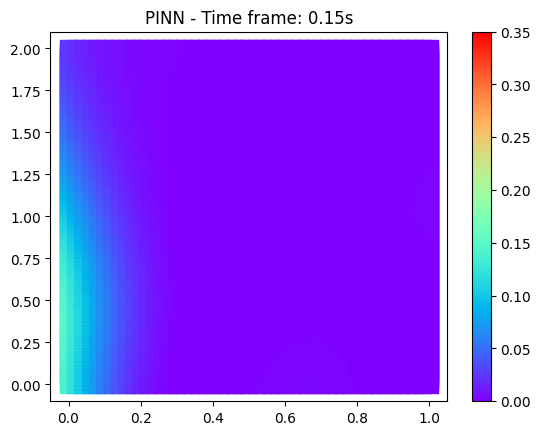

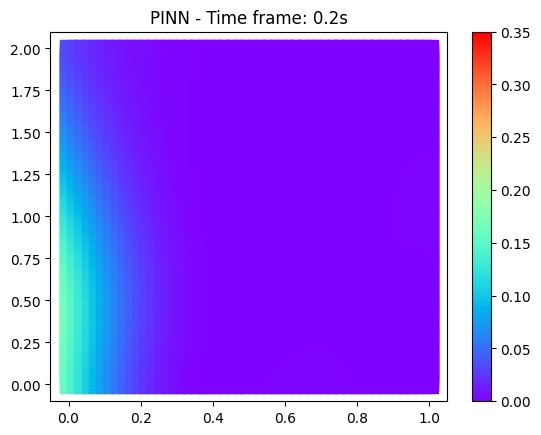

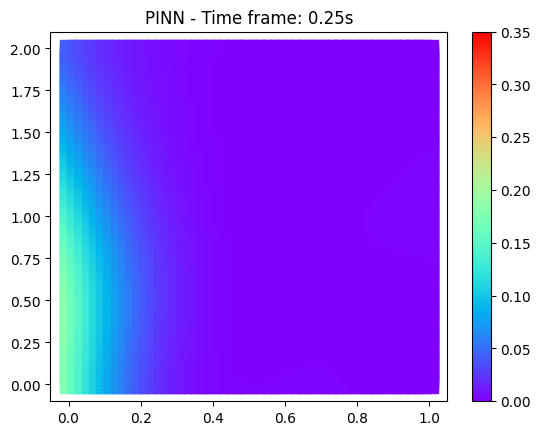

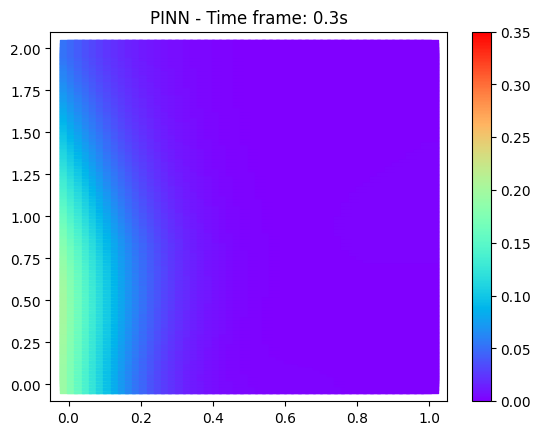

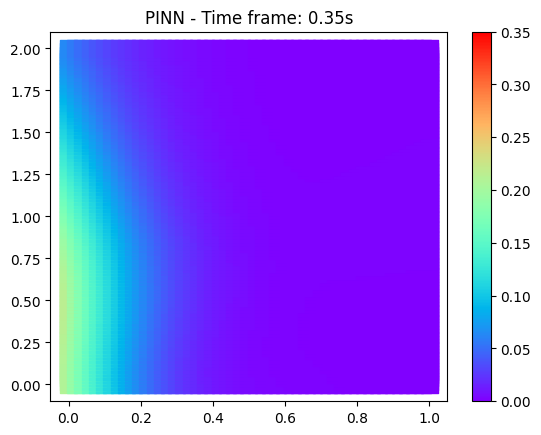

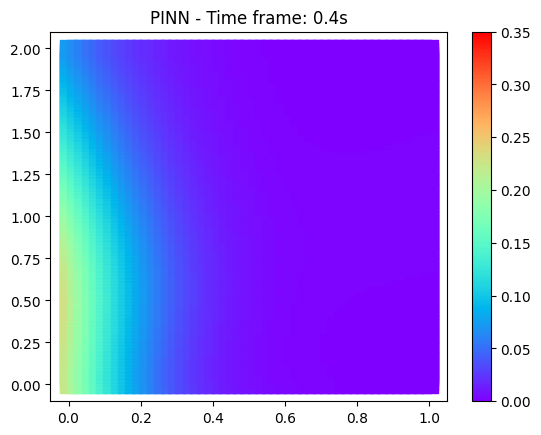

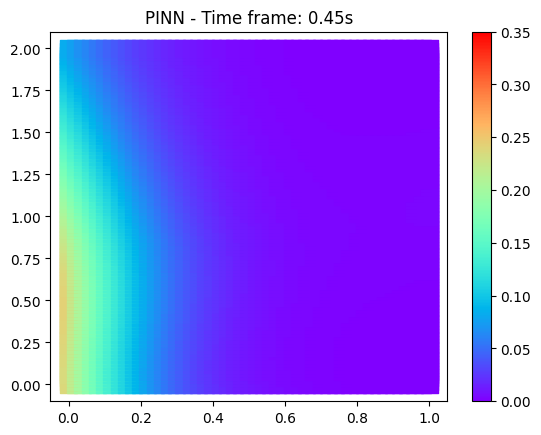

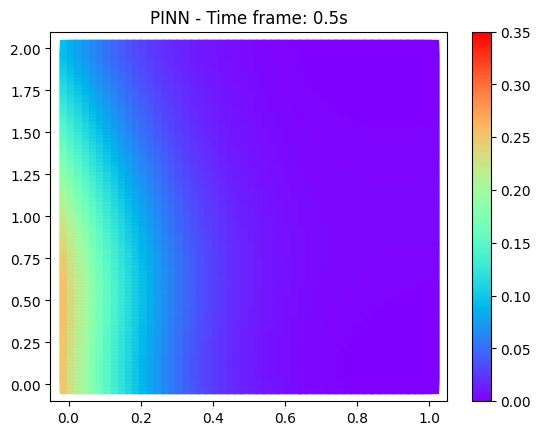

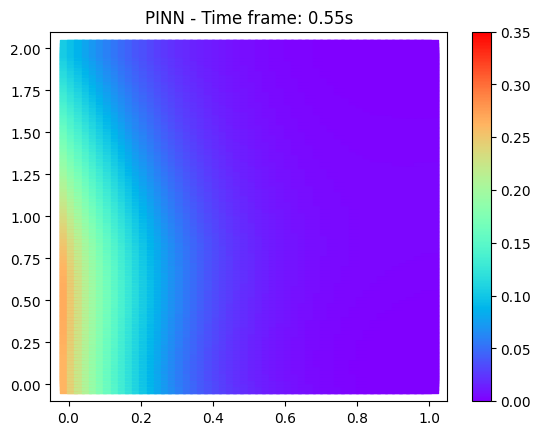

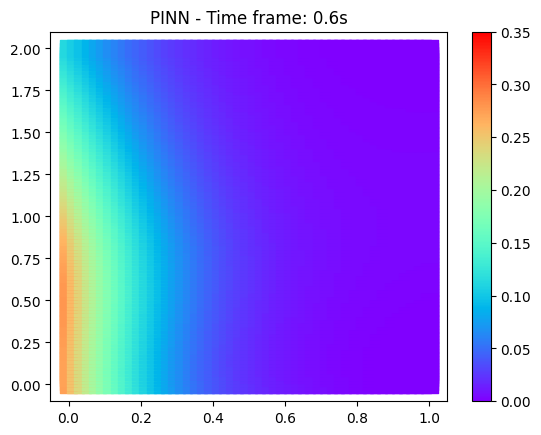

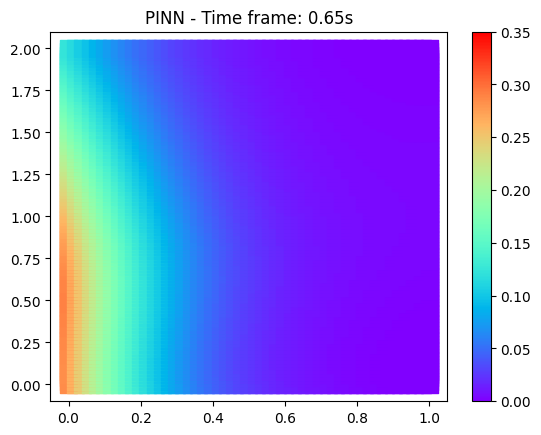

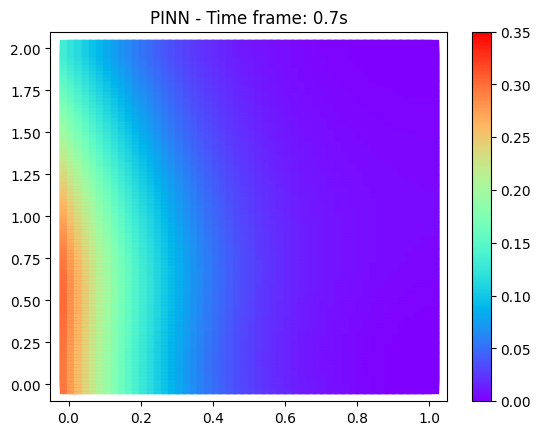

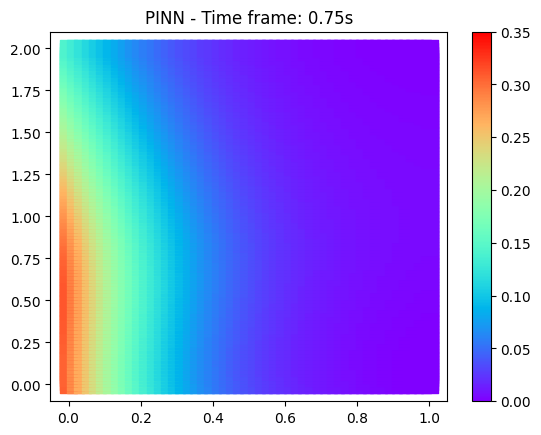

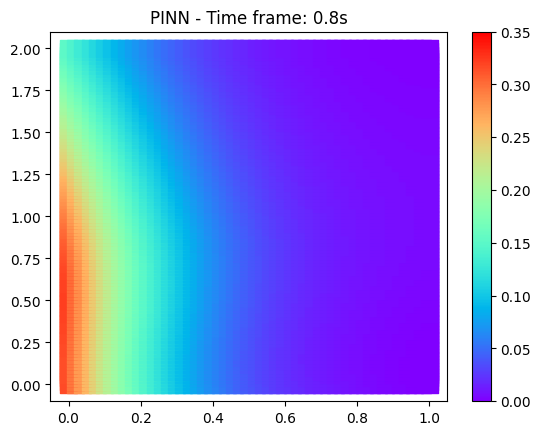

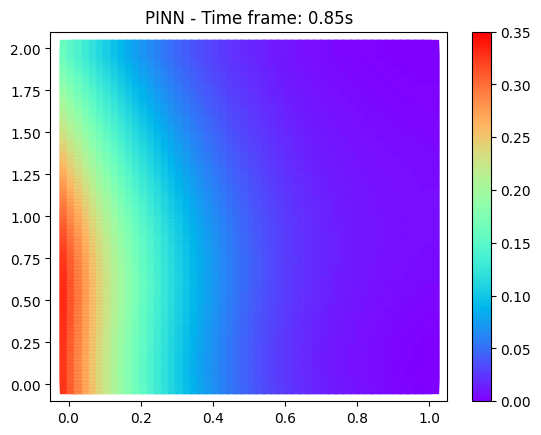

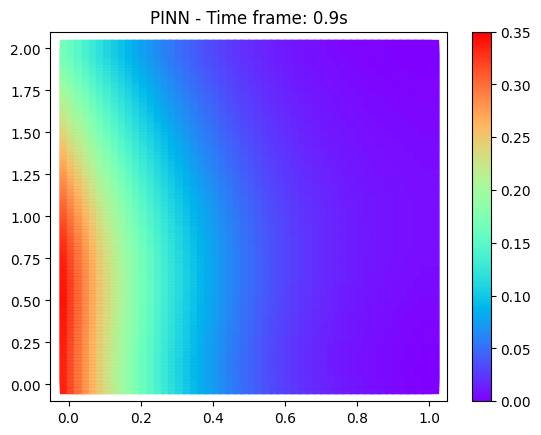

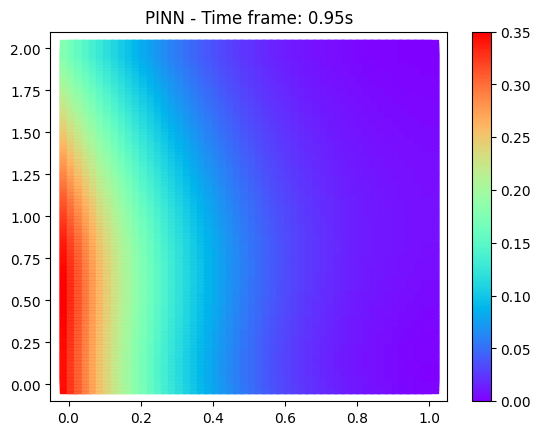

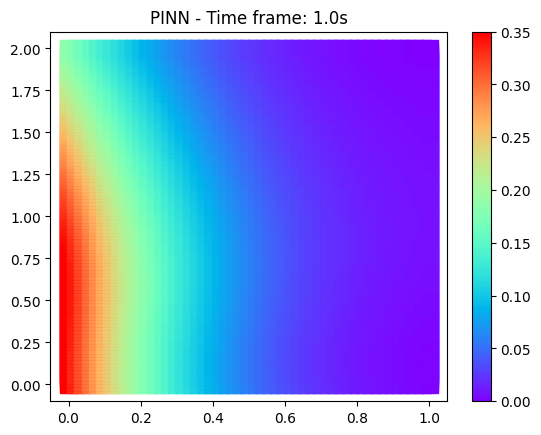

In [ ]:
# Plotting PINN heatmap
low = 0
up = 0.35
for f in range(1, len(ut)) :
  pltx_pinn = []
  plty_pinn = []
  pltz_pinn = []
  for i in range(len(model_X_pinn)) :
    if model_X_pinn[i][3] == ut[f] :
      pltx_pinn.append(model_X_pinn[i][0])
      plty_pinn.append(model_X_pinn[i][1])
      pltz_pinn.append(model_X_pinn[i][2])
  
  s = [150 for n in range(len(pltx_pinn))]
  plt.scatter(pltx_pinn, plty_pinn, c = pltz_pinn, s = s,marker = 's', cmap = 'rainbow', vmin = low, vmax = up)
  plt.title(f"PINN - Time frame: {round(ut[f], 2)}s")
  plt.colorbar()
  plt.show()